This notebook explores how different components of error in topographic differencing data create distinct statistical patterns in the differencing results that can be used in large scale error estimations. We begin by introducing the theoretical framework of the error calculations, illustrated with schematic and synthetic examples. We then apply these calculations to real differencing data and discuss the use-case, assumptions and limitations of error estimations using this method.

The ultimate goal is

## Theoretical framework

Dividing error into multiple components involves looking at different spatial scales, from uncertainty affecting only a single DTM cell to that uniformly affecting the entire area of interest. There have been different approaches to dealing with this spatial variation in uncertainty.

### Synthetic data

Throughout the theoretical framework section, we will illustrate the statistical fingerprint of each error component by looking at the distribution of errors of a specific type across a raster dataset. Since differencing results from real data will likely contain some amount of all three components of error, we will use synthetic differencing results to isolate each component. We will use identical rasters as the base for both the compare and reference datasets, assume no real change between them, and modify them to add the specific component of error in which we are interested in observing.  

We choose four examples contrasting two parameters:\
    - **relief**: Grand Teton, WY (high relief: 1713m; 2014, 5.72 pts/m2); OK Panhandle(low relief: 12m; 2019, 4.97 pts/m2)\
    - **data quality**, as expressed by point density: Porcupine Creek, MN, captured in 2008-2012 (?) (1.20 pts/m2) and 2021 (22.41 pts/m2)

#### Download 3DEP data

In [129]:
#### Import libraries

import geopandas as gpd
import pdal
from osgeo import gdal
from shapely import Point, LineString, Polygon
import requests
import json
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from shapely.ops import transform
from pyproj import Transformer
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
import xarray
import pandas as pd
import seaborn as sns

#### Define functions to query 3DEP data, download pointcloud data and create DTMs

## Most of the core functions (gcs_to_proj, build_pdal_pipeline, make_DEM_pipeline) have been lifted without modification from Speed et al. (2022)

def gcs_to_proj(poly):
    """
    Function for reprojecting polygon shapely object from geographic coordinates (EPSG:4326) 
    to Web Mercator (EPSG: 3857)). 
    
    :param poly: shapely polygon for user area of interest (AOI)
    """
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True).transform
    user_poly_proj3857 = transform(project, poly)
    return(user_poly_proj3857)

# Get GeoJSON file for 3DEP outlines from URL
#request the boundaries from the Github repo and save locally.
url = 'https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson'
r = requests.get(url)
with open('resources.geojson', 'w') as f:
    f.write(r.content.decode("utf-8"))

with open('resources.geojson', 'r') as f:
    geojsons_3DEP = json.load(f)
    
#make pandas dataframe and create pandas.Series objects for the names, urls, and number of points for each boundary.
with open('resources.geojson', 'r') as f:
    df = gpd.read_file(f)
    names = df['name']
    urls = df['url']
    num_points = df['count']

#project the boundaries to EPSG 3857 (necessary for API call to AWS for 3DEP data)
projected_geoms = []
for geometry in df['geometry']:
        projected_geoms.append(gcs_to_proj(geometry))

geometries_GCS = df['geometry']
geometries_EPSG3857 = gpd.GeoSeries(projected_geoms)

def get_intersecting_datasets(bounds_3857):
    intersecting_polys = []

    for i,geom in enumerate(geometries_EPSG3857):
        if geom.intersects(bounds_3857):
            #intersecting_polys.append((names[i], geometries_EPSG3857[i].area, urls[i], num_points[i], num_points[i]/geometries_EPSG3857[i].area))
            intersecting_polys.append((names[i], geometries_GCS[i], geometries_EPSG3857[i], urls[i], num_points[i])) # get a rough estimate of data density by computing number of returns/polygon area
    
    return intersecting_polys

def build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_names, pc_resolution, filterNoise = False,
                        reclassify = False, savePointCloud = True, outCRS = 3857, pc_outName = 'filter_test', 
                        pc_outType = 'laz'):

    """
    Build pdal pipeline for requesting, processing, and saving point cloud data. Each processing step is a 'stage' 
    in the final pdal pipeline. Each stages is appended to the 'pointcloud_pipeline' object to produce the final pipeline.
    
    Parameters:
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857)Polygon is generated 
                            either through the 'handle_draw' methor or by inputing their own shapefile.
    :param usgs_3dep_dataset_names: List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set 
                                determined through intersecttino of the 3DEP and AOI polys.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:
        
                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.
                            
    :param filterNoise: Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    :param savePointCloud: Option to save (or not) the point cloud data. If savePointCloud == False, 
           the pc_outName and pc_outType parameters are not used and can be any value.
    :param outCRS: Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False, 
                  pc_outName can be in value. If a different file type is requested,the user will get error.
    :raise Exception: If user passes in argument that is not 'las' or 'laz'.
    """
    
    #this is the basic pipeline which only accesses the 3DEP data
    readers = []
    for name in usgs_3dep_dataset_names:
        url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{}/ept.json".format(name)
        reader = {
            "type": "readers.ept",
            "filename": str(url),
            "polygon": str(extent_epsg3857),
            "requests": 3,
            "resolution": pc_resolution
        }
        readers.append(reader)
        
    pointcloud_pipeline = {
            "pipeline":
                readers
    }
    
    if filterNoise == True:
        
        filter_stage = {
            "type":"filters.range",
            "limits":"Classification![7:7], Classification![18:18]"
        }
        
        pointcloud_pipeline['pipeline'].append(filter_stage)
    
    if reclassify == True:
        
        remove_classes_stage = {
            "type":"filters.assign",
            "value":"Classification = 0"
        }
        
        classify_ground_stage = {
            "type":"filters.smrf"
        }
        
        reclass_stage = {
            "type":"filters.range",
            "limits":"Classification[2:2]"
        }

    
        pointcloud_pipeline['pipeline'].append(remove_classes_stage)
        pointcloud_pipeline['pipeline'].append(classify_ground_stage)
        pointcloud_pipeline['pipeline'].append(reclass_stage)
        
    reprojection_stage = {
        "type":"filters.reprojection",
        "out_srs":"EPSG:{}".format(outCRS)
    }
    
    pointcloud_pipeline['pipeline'].append(reprojection_stage)
    
    if savePointCloud == True:
        
        if pc_outType == 'las':
            savePC_stage = {
                "type": "writers.las",
                "filename": str(pc_outName)+'.'+ str(pc_outType),
            }
        elif pc_outType == 'laz':    
            savePC_stage = {
                "type": "writers.las",
                "compression": "laszip",
                "filename": str(pc_outName)+'.'+ str(pc_outType),
            }
        else:
            raise Exception("pc_outType must be 'las' or 'laz'.")

        pointcloud_pipeline['pipeline'].append(savePC_stage)
        
    return pointcloud_pipeline


def make_DEM_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution, dem_resolution,
                      filterNoise = True, reclassify = True, savePointCloud = False, outCRS = 3857,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = 'dem_test', dem_outExt = 'tif', driver = "GTiff"):
    
    """
    Build pdal pipeline for creating a digital elevation model (DEM) product from the requested point cloud data. The 
    user must specify whether a digital terrain (bare earth) model (DTM) or digital surface model (DSM) will be created, 
    the output DTM/DSM resolution, and the gridding method desired. 

    The `build_pdal_pipeline() method is used to request the data from the Amazon Web Services ept bucket, and the 
    user may define any processing steps (filtering, reclassifying, reprojecting). The user must also specify whether 
    the point cloud should be saved or not. Saving the point cloud is not necessary for the generation of the DEM. 

    
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857). Polygon is generated 
                         either through the 'handle_draw' methor or by inputing their own shapefile.
                         This parameter is set automatically when the user-defined AOI is chosen.
    :param usgs_3dep_dataset_names: List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set 
                                determined through intersecttino of the 3DEP and AOI polys.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:

                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length. 
                            Units correspond to resource coordinate system units. For example, 
                            for a coordinate system expressed in meters, a resolution value of 0.1 
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible 
                            resolution that is at least as precise as the requested resolution will be selected. 
                            Therefore the result may be a bit more precise than requested.


   
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False, 
                  pc_outName can be in value. If a different file type is requested,the user will get error.
    :raise Exception: If user passes in argument that is not 'las' or 'laz'.
    
    :param dem_resolution: Desired grid size (in meters) for output raster DEM 
    :param filterNoise: Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    :param savePointCloud: Option to save (or not) the point cloud data. If savePointCloud == False, 
           the pc_outName and pc_outType parameters are not used and can be any value.

    :param outCRS: Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False, 
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If a different file type is requested,
                  the user will get error stating "Extension must be 'las' or 'laz'". If savePointcloud = False, 
                  pc_outName can be in value.
    :param demType: Type of DEM produced. Input must 'dtm' (digital terrain model) or 'dsm' (digital surface model).
    :param gridMethod: Method used. Options are 'min', 'mean', 'max', 'idw'.
    :param dem_outName: Desired name of DEM file on user's local file system.
    :param dem_outExt: DEM file extension. Default is TIF.
    :param driver: File format. Default is GTIFF
    :raise Exception: If user passes in argument that is not 'dtm' or 'dsm'
    """

    dem_pipeline = build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_name, pc_resolution,
                                              filterNoise, reclassify, savePointCloud, outCRS, pc_outName, pc_outType)
    
    if demType == 'dsm':
        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    elif demType == 'dtm':
        groundfilter_stage = {
                "type":"filters.range",
                "limits":"Classification[2:2]"
        }

        dem_pipeline['pipeline'].append(groundfilter_stage)

        dem_stage = {
                "type":"writers.gdal",
                "filename":str(dem_outName)+ '.' + str(dem_outExt),
                "gdaldriver":driver,
                "nodata":-9999,
                "output_type":gridMethod,
                "resolution":float(dem_resolution),
                "gdalopts":"COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        }
    
    else:
        raise Exception("demType must be 'dsm' or 'dtm'.")
        
        
    dem_pipeline['pipeline'].append(dem_stage)
    
    return dem_pipeline

def native_utm_crs_from_aoi_bounds(bounds,datum):
    """
    Get the native UTM coordinate reference system from the 

    :param bounds: shapely Polygon of bounding box in EPSG:4326 CRS
    :param datum: string with datum name (e.g., "WGS84")
    :return: UTM CRS code
    """
    utm_crs_list = query_utm_crs_info(
        datum_name=datum,
        area_of_interest=AreaOfInterest(
            west_lon_degree=bounds[0],
            south_lat_degree=bounds[1],
            east_lon_degree=bounds[2],
            north_lat_degree=bounds[3],
        ),
    )
    utm_crs = CRS.from_epsg(utm_crs_list[0].code)
    return utm_crs

def info_from_bounds(xmin,xmax,ymin,ymax):
    bounds_3857=Polygon((Point(xmin,ymax),Point(xmax,ymax),Point(xmax,ymin),Point(xmin,ymin)))
    project = pyproj.Transformer.from_crs(CRS('EPSG:3857'), CRS('EPSG:4326'), always_xy=True).transform
    bounds_4326 = transform(project, bounds_3857)
    native_utm=native_utm_crs_from_aoi_bounds(bounds_4326.bounds,"WGS84").to_epsg()
    intersecting_polys = get_intersecting_datasets(bounds_3857)
    return bounds_3857, native_utm, intersecting_polys

In [12]:
path="Rasters/"

In [17]:
%%time
#Define bounds and CRS for high relief example
xmin= -12337337.659625944
xmax= -12327209.753378158
ymin=5423207.156833255
ymax=5428634.185841503

bounds_3857, native_utm, intersecting_polys=info_from_bounds(xmin,xmax,ymin,ymax)
grand_teton_high_relief=intersecting_polys[0] # USGS LPC WY GrandTetonElkRefuge 2014 LAS 2016; 08/27/2014 - 09/11/2014; 5.72 pts/m2

#Download DTM for high relief example
### Modified from Speed et al. (2022)

usgs_3dep_dataset = [grand_teton_high_relief[0]]                
pointcloud_resolution = 0.1
dtm_resolution = 1.0
dtm_pipeline = make_DEM_pipeline(bounds_3857, usgs_3dep_dataset, pointcloud_resolution, dtm_resolution,
                                 filterNoise = True, reclassify = False, savePointCloud = False, outCRS = native_utm,
                                 pc_outName = 'grand_teton_high_relief', pc_outType = 'laz', demType = 'dtm', 
                                 gridMethod='idw', dem_outName = path+'grand_teton_high_relief_dtm_1m_t1', dem_outExt = 'tif', driver = "GTiff")

dtm_pipeline = pdal.Pipeline(json.dumps(dtm_pipeline))
dtm_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 7min 35s, sys: 35 s, total: 8min 10s
Wall time: 7min 27s


42989224

In [18]:
%%time
#Define bounds and CRS for low relief example

xmin=-11328514.59434760
xmax=-11324176.792991603
ymin=4407707.7948647225
ymax=4410363.9815977225

bounds_3857, native_utm, intersecting_polys=info_from_bounds(xmin,xmax,ymin,ymax)
ok_panhandle_low_relief=intersecting_polys[0] # OK Panhandle B2 2018; 01/08/2019 - 03/07/2019; 4.97 pts/m2

#Download DTM for low relief example
### Modified from Speed et al. (2022)

usgs_3dep_dataset = [ok_panhandle_low_relief[0]]                
pointcloud_resolution = 0.1
dtm_resolution = 1.0
dtm_pipeline = make_DEM_pipeline(bounds_3857, usgs_3dep_dataset, pointcloud_resolution, dtm_resolution,
                                 filterNoise = True, reclassify = False, savePointCloud = False, outCRS = native_utm,
                                 pc_outName = 'ok_panhandle_low_relief', pc_outType = 'laz', demType = 'dtm', 
                                 gridMethod='idw', dem_outName = path+'ok_panhandle_low_relief_dtm_1m_t1', dem_outExt = 'tif', driver = "GTiff")

dtm_pipeline = pdal.Pipeline(json.dumps(dtm_pipeline))
dtm_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 1min 26s, sys: 31 s, total: 1min 57s
Wall time: 1min 39s


24443751

In [13]:
%%time
#Define bounds and CRS for both data quality examples
xmin=-10249928.408815
xmax= -10245590.607459
ymin=5998777.979821
ymax=6001434.166554

bounds_3857, native_utm, intersecting_polys=info_from_bounds(xmin,xmax,ymin,ymax)
porcupine_creek_low=intersecting_polys[0] #MN FullState; N/A;  1.20 pts/m2
porcupine_creek_high=intersecting_polys[1] #MN LakeSuperior 1 2021; 04/25/2021 - 05/02/2021; 22.41 pts/m2

#Download DTM for low dataquality example
### Modified from Speed et al. (2022)

usgs_3dep_dataset = [porcupine_creek_low[0]]                
pointcloud_resolution = 0.1
dtm_resolution = 1.0
dtm_pipeline = make_DEM_pipeline(bounds_3857, usgs_3dep_dataset, pointcloud_resolution, dtm_resolution,
                                 filterNoise = True, reclassify = False, savePointCloud = False, outCRS = native_utm,
                                 pc_outName = 'porcupine_creek_low', pc_outType = 'laz', demType = 'dtm', 
                                 gridMethod='idw', dem_outName = path+'porcupine_creek_low_dtm_1m_t1', dem_outExt = 'tif', driver = "GTiff")

dtm_pipeline = pdal.Pipeline(json.dumps(dtm_pipeline))
dtm_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 22.6 s, sys: 2.65 s, total: 25.3 s
Wall time: 18.2 s


2456841

In [14]:
%%time
#Download DTM for high data quality example
### Modified from Speed et al. (2022)

usgs_3dep_dataset = [porcupine_creek_high[0]]                
pointcloud_resolution = 0.1
dtm_resolution = 1.0
dtm_pipeline = make_DEM_pipeline(bounds_3857, usgs_3dep_dataset, pointcloud_resolution, dtm_resolution,
                                 filterNoise = True, reclassify = False, savePointCloud = False, outCRS = native_utm,
                                 pc_outName = 'porcupine_creek_high', pc_outType = 'laz', demType = 'dtm', 
                                 gridMethod='idw', dem_outName = path+'porcupine_creek_high_dtm_1m_t1', dem_outExt = 'tif', driver = "GTiff")

dtm_pipeline = pdal.Pipeline(json.dumps(dtm_pipeline))
dtm_pipeline.execute_streaming(chunk_size=1000000)

CPU times: user 5min 13s, sys: 5.39 s, total: 5min 19s
Wall time: 3min 47s


64001752

### Random, spatially uncorrelated error

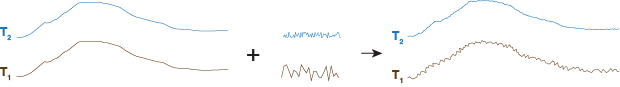

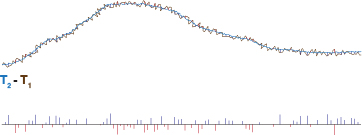

#### Generate synthetic differencing results with random, uncorrelated error for our 4 examples

In [24]:
#List all of the example DTMs
import os

def find_files_with_suffix(directory, suffix):
    """
    Find all files in a directory that end with a specific suffix.

    :param directory: The directory to search in.
    :param suffix: The suffix of the files to find.
    :return: A list of file paths.
    """
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(suffix):
                matching_files.append(os.path.join(root, file))
    return matching_files

original_dtms=find_files_with_suffix(path, '_dtm_1m_t1.tif')

In [95]:
def add_noise_to_raster_handling_nodata(file_path, noise_level, output_path):
    """
    Add random, spatially uncorrelated noise to a raster, handling no data values, and save the result.

    :param file_path: Path to the input raster file.
    :param noise_level: The standard deviation of the noise to be added.
    :param output_path: Path to save the noisy raster.
    """
    with rasterio.open(file_path) as src:
        raster = src.read(1)  # Reading the first band
        nodata = src.nodata  # Get the no data value

        # Create a mask for valid data
        valid_data_mask = raster != nodata

        # Add noise only to valid data
        noise = np.random.normal(0, noise_level, raster.shape)
        noisy_raster = np.where(valid_data_mask, raster + noise, nodata)

        # Save the noisy raster using the same profile as the source
        profile = src.profile
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(noisy_raster, 1)


In [126]:
#Loop through the list of DTMs and generate the first set of noisy DTMs (t1 DTMs should have a higher amount of noise)
for file in original_dtms:
    noise_level=2
    output_path=file[:-len('_dtm_1m_t1.tif')]+'_random_noise_t1.tif'
    add_noise_to_raster(file, noise_level, output_path)

#Then the second set of noisy DTMs (t2 DTMs should have a lower amount of noise, reflecting increasing data quality with age)
for file in original_dtms:
    noise_level=1
    output_path=file[:-len('_dtm_1m_t1.tif')]+'_random_noise_t2.tif'
    add_noise_to_raster(file, noise_level, output_path)
    
# Compute the vertical topographic differencing results for the synthetic examples
dtm1_names=find_files_with_suffix(path, 'random_noise_t1.tif')
dtm2_names=find_files_with_suffix(path, 'random_noise_t2.tif')

for a in range(0,len(dtm1_names)):
    dtm1_name=dtm1_names[a]
    dtm2_name=dtm2_names[a]
    dtm1 = rioxarray.open_rasterio(dtm1_name, masked=True) 
    dtm2 = rioxarray.open_rasterio(dtm2_name, masked=True) 
    
    if dtm1.shape == dtm2.shape:
        pass
    elif dtm1.shape > dtm2.shape:
        small = dtm2_name
        large = dtm1_name
        dtm1 = dtm1.rio.reproject_match(dtm2)
    else:
        small = dtm1_name
        large = dtm2_name
        dtm2 = dtm2.rio.reproject_match(dtm1)
            
    dtm1 = dtm1.assign_coords({
    "x": dtm2.x,
    "y": dtm2.y,
    })
    
    topo_diff = dtm2 - dtm1
    topo_diff.compute()
    file_name_diff = dtm1_name[:-len('_t1.tif')]+'_topo_diff.tif'
    topo_diff.rio.to_raster(file_name_diff)

#### Visualize synthetic results

##### Maps

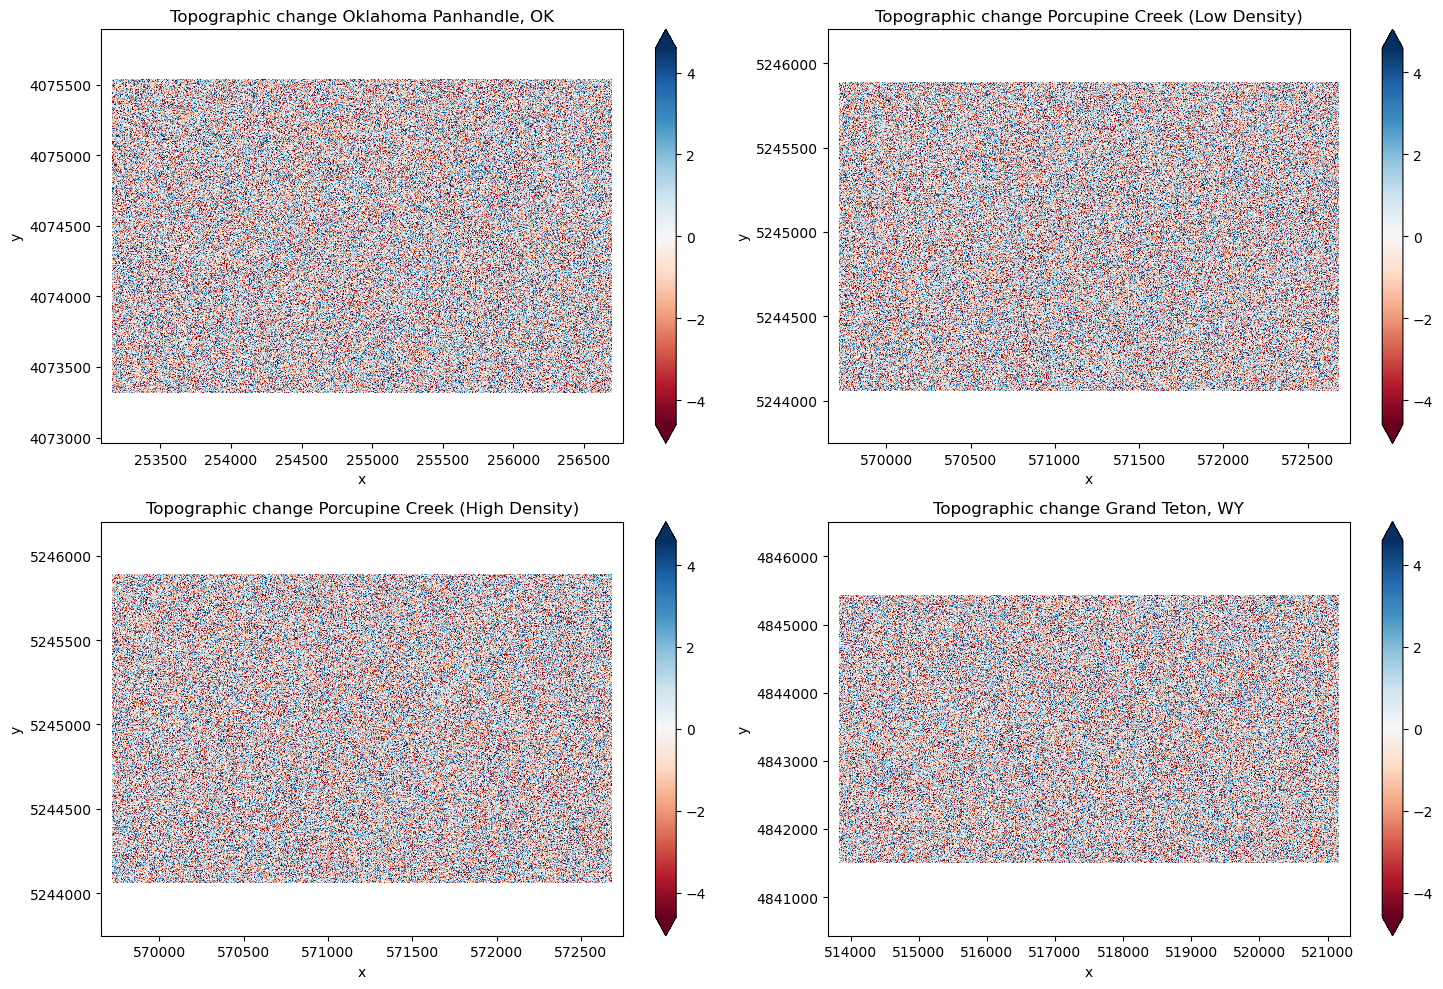

In [127]:
topo_diff_files=find_files_with_suffix(path, 'topo_diff.tif')
topo_diffs=[rioxarray.open_rasterio(topo_diff_files[a], masked=True) for a in range(0,len(topo_diff_files))]
locations= ['Oklahoma Panhandle, OK','Porcupine Creek (Low Density)','Porcupine Creek (High Density)','Grand Teton, WY']

n = len(topo_diffs)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

# Calculate global vmin and vmax across all topo_diffs
global_vmin = min([topo_diff.min() for topo_diff in topo_diffs])
global_vmax = max([topo_diff.max() for topo_diff in topo_diffs])

# Handling case when there's only one plot
if n == 1:
    axs = [axs]

for i, topo_diff in enumerate(topo_diffs):
    ax = axs[i // cols][i % cols] if rows > 1 else axs[i]
    ax.ticklabel_format(style="plain")
    topo_diff.plot(cmap="RdBu", robust=True, ax=ax)
    ax.axis('equal')
    ax.set_title(f"Topographic change {locations[i]}")

# If there are empty subplots, remove their axes
if rows * cols > n:
    for j in range(n, rows * cols):
        ax = axs[j // cols][j % cols] if rows > 1 else axs[j]
        ax.axis('off')

plt.tight_layout()
plt.show()

##### Univariate distributions

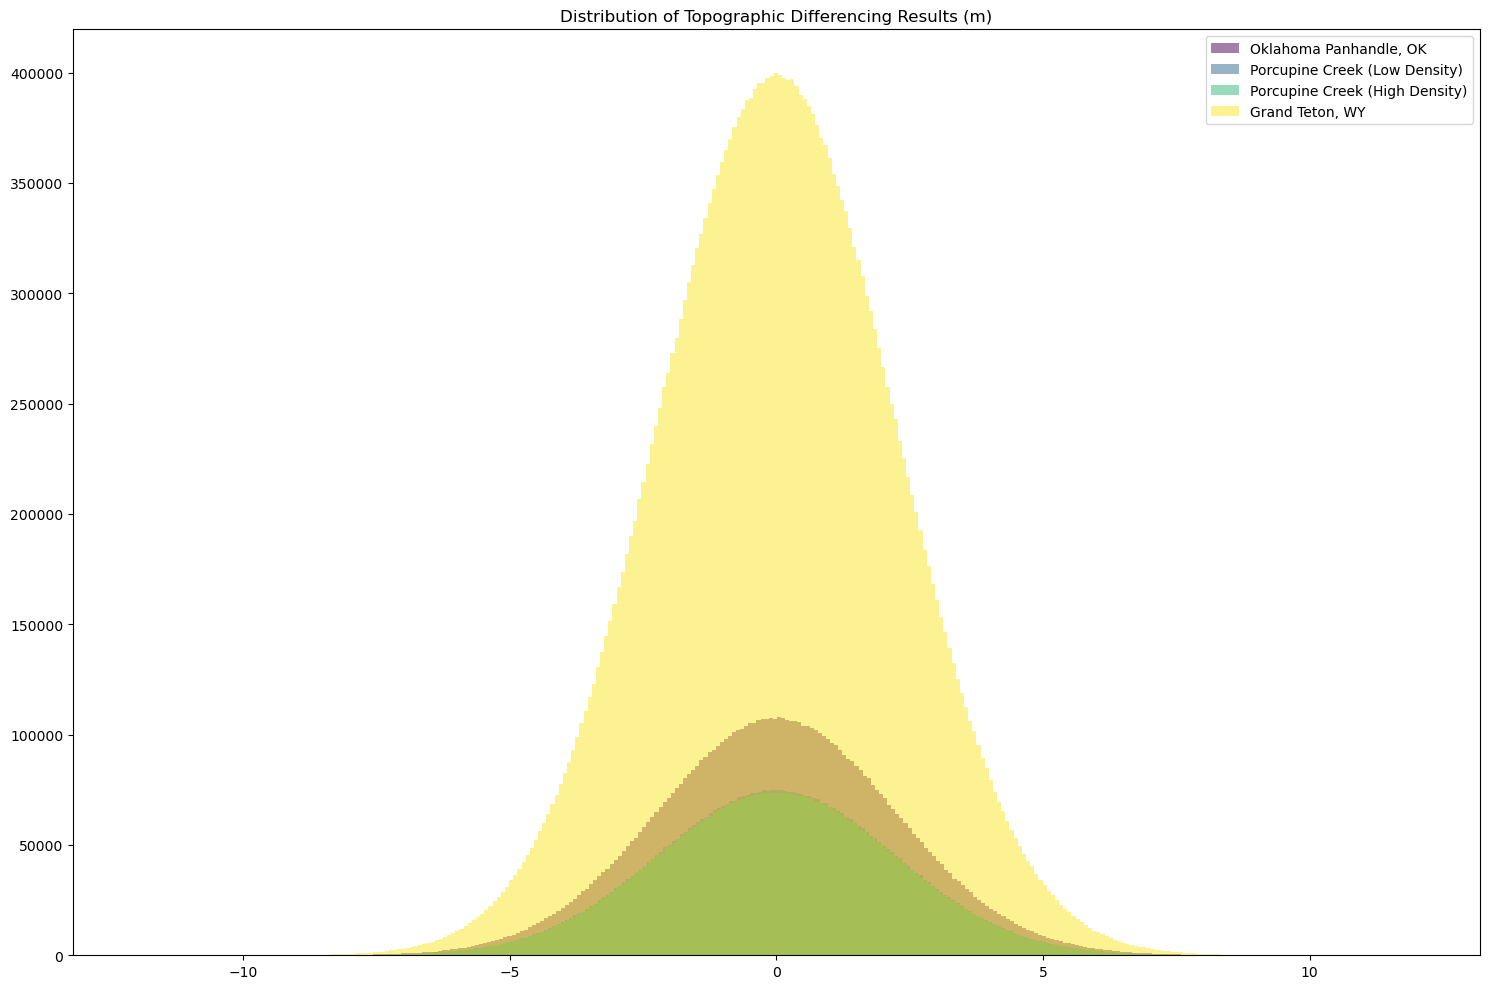

In [132]:
# Create a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(topo_diffs)))

plt.figure(figsize=(15, 10))

for i, topo_diff in enumerate(topo_diffs):
    topo_diff.plot.hist(bins=300, color=colors[i], alpha=0.5, label=f"{locations[i]}")

plt.title("Distribution of Topographic Differencing Results (m)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

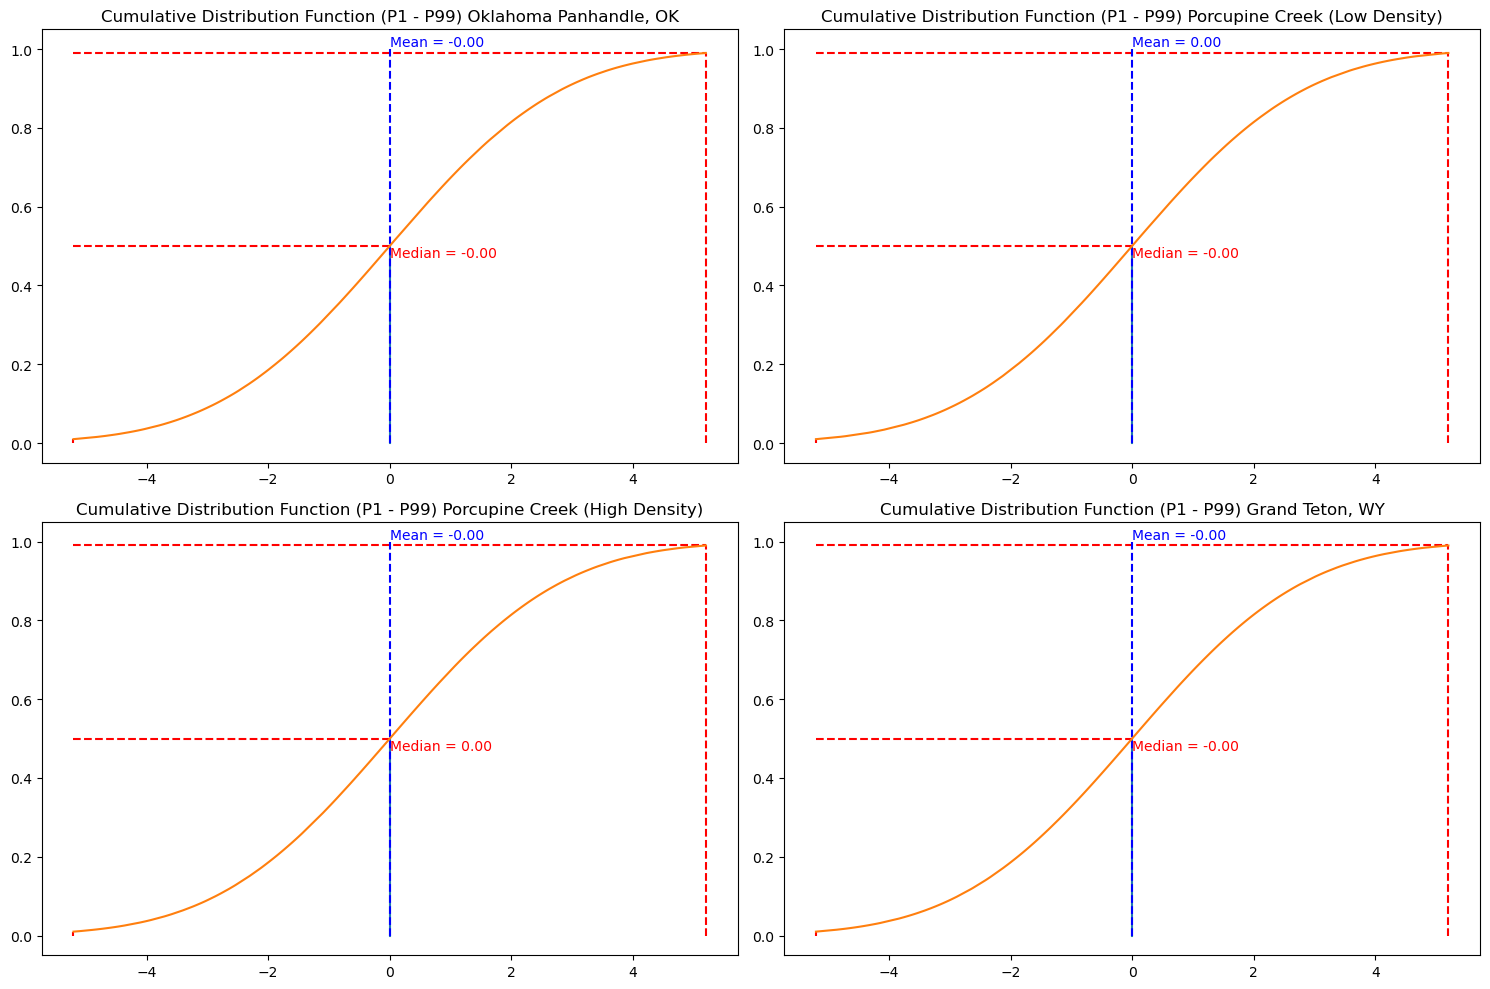

In [153]:
def nonan(x):
    y=x[~np.isnan(x)]
    return y
def inputs_cdf(xarray):
    arr_sorted=np.sort(nonan(xarray.data.flatten()))
    n = len(arr_sorted)
    prob = np.linspace(0,1,num=n)
    return arr_sorted,prob

n = len(topo_diffs)
rows = int(np.ceil(np.sqrt(n)))
cols = int(np.ceil(n / rows))

fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

# Handling case when there's only one plot
if n == 1:
    axs = [axs]

for i, topo_diff in enumerate(topo_diffs):
    ax = axs[i // cols][i % cols] if rows > 1 else axs[i]
    diff_sorted,prob=inputs_cdf(topo_diff)
    filtered_diff_sorted=diff_sorted[(prob >= 0.01) & (prob <= 0.99)]
    filtered_prob=prob[(prob >= 0.01) & (prob <= 0.99)]
    
    mean_value = np.mean(filtered_diff_sorted)
    median_value = np.median(filtered_diff_sorted)
    
    # Plot lines showing P99
    ax.plot([filtered_diff_sorted.max(), filtered_diff_sorted.max()], [0, filtered_prob.max()], 'r--')
    ax.plot([filtered_diff_sorted.min(), filtered_diff_sorted.max()], [filtered_prob.max(), filtered_prob.max()], 'r--')
    
    # Plot lines showing P1
    ax.plot([filtered_diff_sorted.min(), filtered_diff_sorted.min()], [0, filtered_prob.min()], 'r--')
    ax.plot([filtered_diff_sorted.min(), filtered_diff_sorted.min()], [filtered_prob.min(), filtered_prob.min()], 'r--')
    
    #Plot median line
    ax.plot([np.median(filtered_diff_sorted), np.median(filtered_diff_sorted)], [0, 0.5])
    ax.plot([filtered_diff_sorted.min(), np.median(filtered_diff_sorted)], [0.5, 0.5], 'r--')
    
    #Plot mean line
    ax.plot([np.mean(filtered_diff_sorted), np.mean(filtered_diff_sorted)], [0, 1], 'b--')
    
    ax.plot(filtered_diff_sorted,filtered_prob)
    ax.set_title(f"Cumulative Distribution Function (P1 - P99) {locations[i]}")
            
    ax.text(mean_value, 1, f'Mean = {mean_value:.2f}', color='blue', verticalalignment='bottom')
    ax.text(median_value, 0.5, f'Median = {median_value:.2f}', color='red', verticalalignment='top')

# If there are empty subplots, remove their axes
if rows * cols > n:
    for j in range(n, rows * cols):
        ax = axs[j // cols][j % cols] if rows > 1 else axs[j]
        ax.axis('off')

plt.tight_layout()
plt.show()

#### Geostatistics

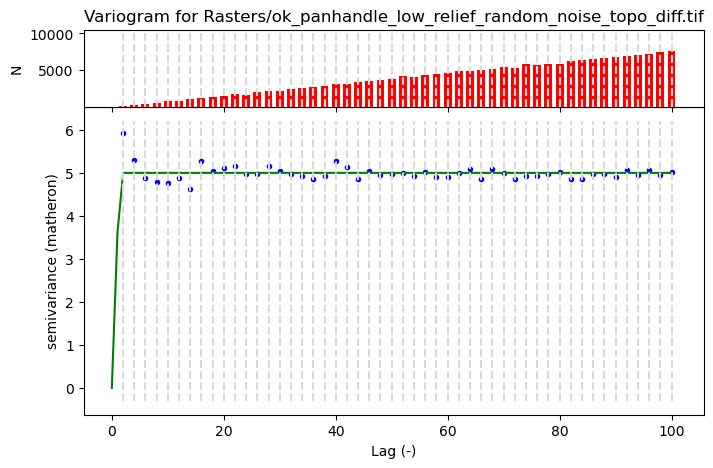

Model parameters for Rasters/ok_panhandle_low_relief_random_noise_topo_diff.tif: [1.8960281633697442, 5.00433300751351, 0]


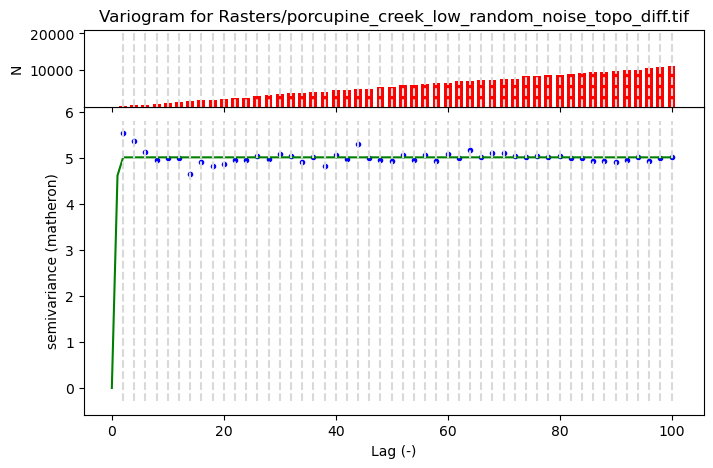

Model parameters for Rasters/porcupine_creek_low_random_noise_topo_diff.tif: [1.3275492125744437, 5.016081369120221, 0]


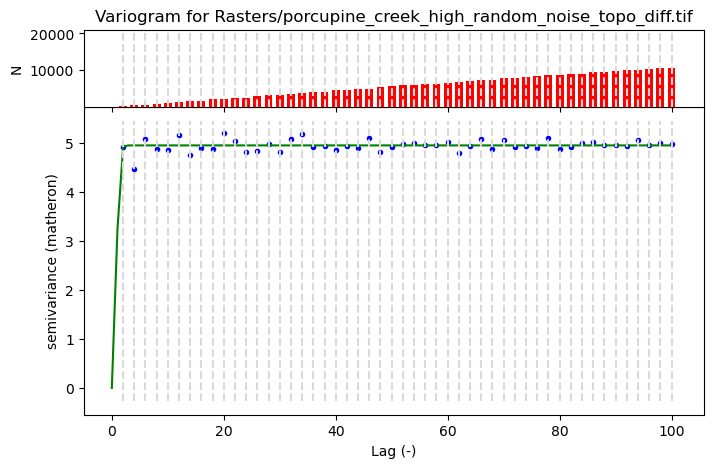

Model parameters for Rasters/porcupine_creek_high_random_noise_topo_diff.tif: [2.1339877306746615, 4.951111019981417, 0]


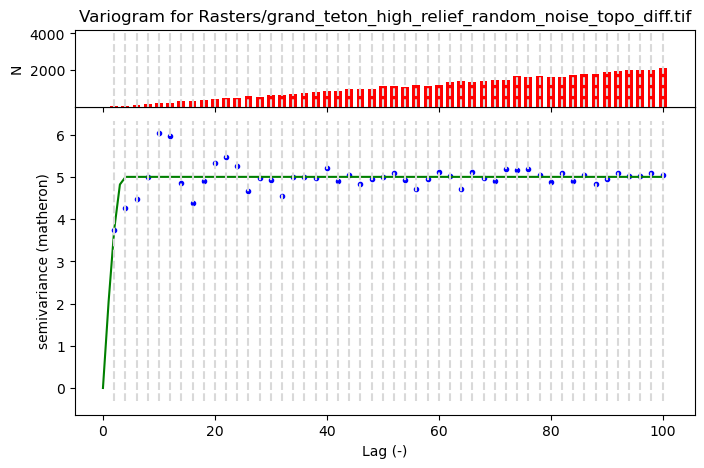

Model parameters for Rasters/grand_teton_high_relief_random_noise_topo_diff.tif: [3.603822742065757, 5.0028292696172585, 0]


In [144]:
# Function to load and process raster data
def process_raster(file_path):
    with rasterio.open(file_path) as src:
        topography = src.read(1)  # Read the first band into a 2D array
        transform = src.transform
        # Mask out no-data values 
        mask = (topography != src.nodata) & np.isfinite(topography)
        indices = np.indices(topography.shape)
        x_indices, y_indices = indices[0][mask], indices[1][mask]
        x_coords, y_coords = rasterio.transform.xy(transform, x_indices, y_indices, offset='center')

    # Flatten the arrays and stack coordinates and values into a single 2-D array
    coords = np.column_stack((x_coords, y_coords))
    values = topography[mask]

    return coords, values

# Loop through the files and plot the variograms
for file in topo_diff_files:  # Assuming topo_diff_files contains the file paths
    coords, values = process_raster(file)

    sample_size = 10000  # taking small sample due to computational limits
    indices = np.random.choice(len(values), size=sample_size, replace=False)

    sample_coords = coords[indices]
    sample_values = values[indices]

    # Calculate the variogram using the sampled data and fit spherical model
    V = Variogram(sample_coords, sample_values, model='spherical', maxlag=100, n_lags=50)

    # Plot the variogram
    V.plot()
    plt.title(f"Variogram for {file}")
    plt.show()

    print(f'Model parameters for {file}:', V.parameters)

#### Other thoughts

##### How does amount of compare and reference DTM noise affect random, uncorrelated topographic differenceing error?

In [170]:
path_noise_level='Rasters/Noise_levels/'
#Let's take Grand Teton as an example and vary the level of noise in the compare and reference datasets
noise_levels=np.linspace(0,5,11)
pairs = [(x, y) for x in noise_levels for y in noise_levels if x > y] #pairs of noise levels so that noise of t1 > t2
file='grand_teton_high_relief_dtm_1m_t1.tif'

for a in range(0,len(pairs)):
    input_file="Rasters/"+file
    noise_level1=pairs[a][0]
    noise_level2=pairs[a][1]
    output_path1=path_noise_level+file[:-len('_dtm_1m_t1.tif')]+'_random_noise_t1'+f'_{a}'+'.tif'
    output_path2=path_noise_level+file[:-len('_dtm_1m_t2.tif')]+'_random_noise_t2'+f'_{a}'+'.tif'
    add_noise_to_raster(input_file, noise_level1, output_path1)
    add_noise_to_raster(input_file, noise_level2, output_path2)

In [178]:
for a in range(0,len(pairs)):
    # Compute the vertical topographic differencing results for the synthetic examples
    dtm1_name=find_files_with_suffix(path_noise_level, f'_t1_{a}.tif')[0]
    dtm2_name=find_files_with_suffix(path_noise_level, f'_t2_{a}.tif')[0]
    dtm1 = rioxarray.open_rasterio(dtm1_name, masked=True) 
    dtm2 = rioxarray.open_rasterio(dtm2_name, masked=True) 
    
    if dtm1.shape == dtm2.shape:
        pass
    elif dtm1.shape > dtm2.shape:
        small = dtm2_name
        large = dtm1_name
        dtm1 = dtm1.rio.reproject_match(dtm2)
    else:
        small = dtm1_name
        large = dtm2_name
        dtm2 = dtm2.rio.reproject_match(dtm1)
            
    dtm1 = dtm1.assign_coords({
    "x": dtm2.x,
    "y": dtm2.y,
    })
    
    topo_diff = dtm2 - dtm1
    topo_diff.compute()
    file_name_diff = dtm1_name[:-len(f'_t1_{a}.tif')]+f'_topo_diff_{a}.tif'
    topo_diff.rio.to_raster(file_name_diff)

In [ ]:
# Let's use the interquartile range of the differencing results to answer the question



#### Synthesis

No spatial patterns appear in the maps.\
Errors are normally distributed, and the range of values does not vary between the examples.\
For the semi-variogram analysis, the range is very close to the lag spacing, indicating that there is little to no degree of spatial correlation, based on the sampling of data. 

### Random, spatially correlated error

#### Generate synthetic differencing results with random, correlated error for our 4 examples

#### Visualize synthetic results

##### Maps

##### Univariate analysis

##### Geostatistics

#### Synthesis

### Systematic error

#### Generate synthetic differencing results with systematic error for our 4 examples

#### Visualize synthetic results

##### Maps

##### Univariate analysis

##### Geostatistics

#### Synthesis

### Additive patterns